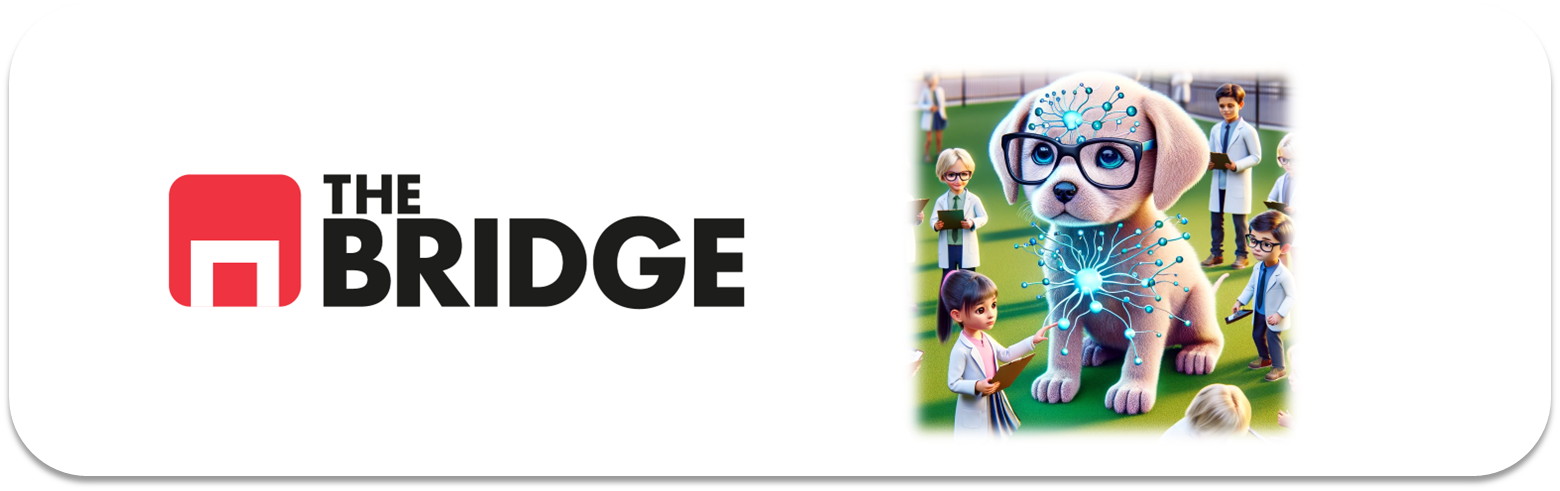

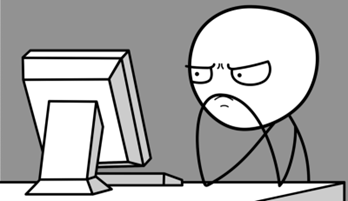

Para ejercitarte y afianzar lo aprendido sobre **Embeddings y procesamiento de texto**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios). 

La solución a los mismos las tienes ya, y en este caso se te invita a QUE SIGAS EL EJERCICIO CON LA SOLUCION a modo de tutorial ya que hay varios aspectos que son nuevos y se introducen en la solución.

### Ejercicio 0

Importa las librerías necesarias

### Ejercicio 1: Descarga el dataset

Usarás el [Conjunto de Datos de Grandes Reseñas de Películas](http://ai.stanford.edu/~amaas/data/sentiment/) a lo largo del tutorial. Entrenarás un modelo de clasificador de sentimientos con este conjunto de datos y, en el proceso, aprenderás embeddings desde cero. 

Descarga el conjunto de datos utilizando la utilidad de archivos de Keras y echa un vistazo a los directorios.

In [ ]:
x

### Ejercicio 2

Echa un vistazo al directorio train/. Tiene carpetas pos y neg con reseñas de películas etiquetadas como positivas y negativas respectivamente. Utilizarás reseñas de las carpetas pos y neg para entrenar un modelo de clasificación binaria.

### Ejercicio 3

El directorio `train` también tiene carpetas adicionales que deberían ser eliminadas antes de crear el conjunto de datos de entrenamiento.

### Ejercicio 4

A continuación, crea un tf.data.Dataset usando tf.keras.preprocessing.text_dataset_from_directory. Puedes leer más sobre cómo utilizar esta utilidad en este [tutorial de clasificación de texto](https://www.tensorflow.org/tutorials/keras/text_classification).

Usa el directorio de entrenamiento para crear conjuntos de datos de entrenamiento y validación con una división del 20% para la validación.

### Ejercicio 5: Configura el dataset para mejorar el rendimiento (mira la solución)

Estos son dos métodos importantes que deberías usar al cargar datos para asegurarte de que las operaciones de entrada/salida no se conviertan en un bloqueo.

`.cache()` mantiene los datos en memoria después de ser cargados desde el disco. Esto garantizará que el conjunto de datos no se convierta en un cuello de botella mientras entrenas tu modelo. Si tu conjunto de datos es demasiado grande para caber en la memoria, también puedes usar este método para crear una caché en disco eficiente, la cual es más eficiente para leer que muchos archivos pequeños.

`.prefetch()` solapa la preprocesación de datos y la ejecución del modelo durante el entrenamiento.

Puedes aprender más sobre ambos métodos, así como cómo cachear datos en disco en la [guía de rendimiento de datos](https://www.tensorflow.org/guide/data_performance).



### Ejercicio 6: Repasando Embeddings 

Crea una capa de Embedding con dimensión de entrada 1000 y dimensión de salida 4. Codifica las frases "Me llamo Iñigo Montoya", "Tú mataste a mi padre", "Disponte a morir" (tendrás que crear una capa adicional). Haz la codificación de cada una por separado y luego prueba a ponerlas todas juntas en una misma lista. Ojo, cada frase la tienes que convertir a una lista de palabras. ¿Qué ocurre en este último caso? [Haz el ejercicio y luego mira la solución]

### Ejercicio 7: Procesado de Texto con vectorización

A continuación, define los pasos de preprocesamiento del conjunto de datos necesarios para tu modelo de clasificación de sentimientos. Inicializa una capa de TextVectorization con los parámetros deseados para vectorizar las reseñas de películas. Recuerda que tendrás que limipiar (tambien se llama "estandandizar") las reseñas (como lo hicimos en su día o como en el workout o como lo hacemos, diferente, en la solución).

Importante: En este ejercicio vamos a usar la capa de vectorización pero no para convertir las frases en conteos de palabras o sus tfidf, sino en listas de indices en un vocabulario. Por eso a la hora de inicializar la capa debes usar el output_mode = "int" (en el workout lo hemos empleado con "count" y con "tf-idf". Configura la capa de forma que ajuste su salida a secuencias o frases de 8 palabras.

Prueba la nueva capa con las frases del ejercicio anterior.


### Ejercicio 8

Recrea la capa del ejercicio anterior, llamándola vectorizer_layer. pero esta vez para un vocabulario de 1000 terminos y para un tamaño de secuencia de 100 palabras. LUEGO ejecuta el código que tienes en la siguiente celda.

**Para ejecutar después de la creación de la capa vectorize_layer**

In [ ]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
# Nos quitamos los labels de esta manera, que van en conjunto con features en train_ds
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

### Ejercicio 9

Es hora de crear el modelo de clasificación. Tendrás que emplear una capa ["GlobalAveragePooling1D"](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) e investigar por tu cuenta un poco sobre ella, aunque aquí te dejo algunos apuntes. En definitiva, tu modelo tiene que tener:

* La capa [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) transforma cadenas en índices de vocabulario. Ya has inicializado `vectorize_layer` como una capa de TextVectorization y has construido su vocabulario llamando a `adapt` en `text_ds`. Ahora, vectorize_layer puede ser utilizada como la primera capa de tu modelo de clasificación de principio a fin, alimentando cadenas transformadas en la capa de Embedding. Utiliza una dimensión de salida de 16 en el embedding.
  
* La capa [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) toma el vocabulario codificado en enteros y busca el vector de incrustación para cada índice de palabra. Estos vectores se aprenden a medida que el modelo se entrena. Los vectores añaden una dimensión al arreglo de salida. Las dimensiones resultantes son: `(lote, secuencia, incrustación)`.

* La capa [`GlobalAveragePooling1D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) devuelve un vector de salida de longitud fija para cada ejemplo promediando sobre la dimensión de secuencia. Esto permite al modelo manejar entrada de longitud variable, de la manera más simple posible. Esta capa hace el sentence embedding que comentamos en el workout, es decir convierte la sentencia en un embedding que es el resultado de hacer la media de cada uno de sus word embeddings (sí es el centroide de sus embeddings) ya que es la forma más sencilla de hacer sentence embedding. 

* El vector de salida de longitud fija se pasa a través de una capa completamente conectada ([`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) con 16 unidades ocultas. (porque tenemos 16 de dimensión del embedding de palabra y de sentencia).

* La última capa está densamente conectada con un único nodo de salida (por ser un clasificador binario).

Precaución: Este modelo no utiliza enmascaramiento, por lo que el relleno de ceros se utiliza como parte de la entrada y, por lo tanto, la longitud del relleno puede afectar la salida. Para solucionar esto, consulta la [guía de enmascaramiento y relleno](https://www.tensorflow.org/guide/keras/masking_and_padding). Básicamente, al hacer el sentence embedding en frases cortas (imaginate una de una sola palabra, tendrá en nuestro caso 1 word-embedding y 99 de relleno) el embedding de la sentencia se ve completamente sesgado hacia el de relleno, por eso se usa el masking para decirle a la capa que sólo tenga en cuenta el embedding que no sea de relleno.y relleno.

### Ejercicio 10

Entrena el modelo usando un optimizador "Adam" y la función de perdida "BinaryCrossEntropy". Evalua contra test. Prueba con 15 épocas (es muy pesado el entrenamiento).

### Bonus: Masking

Cuando hayas completado los ejercicios, lee este apartado de la solución.